✅ Librerías cargadas correctamente
   - SMOTE disponible: ✅
   - XGBoost disponible: ✅
📊 DATASETS CARGADOS (VERSIÓN 3.0 - NOMBRES + PREFERENCIAS)

✅ Docentes: 307 registros, 90 columnas
✅ Materias: 49 registros
✅ Perfiles Ideales: 7 áreas

📊 Distribución de docentes por área:
area_principal
Software                 73
Gestión Computacional    58
Programación             52
Base de Datos            36
Matemáticas              36
Administración           28
Computación              24
Name: count, dtype: int64

✅ Columna 'materias_preferidas' detectada
   - Promedio materias preferidas: 3.9

📋 Muestra de docentes con nombres reales:
id_docente              nombres_completos area_principal  num_preferencias
   DOC_001  ALARCON SALVATIERRA JOSE ABEL    Computación                 5
   DOC_002     ALONSO ANGUIZACA JOSE LUIS       Software                 3
   DOC_003 ALVAREZ SOLIS FRANCISCO XAVIER    Matemáticas                 5
   DOC_004      AVILES MONROY JORGE ISAAC   Programación     

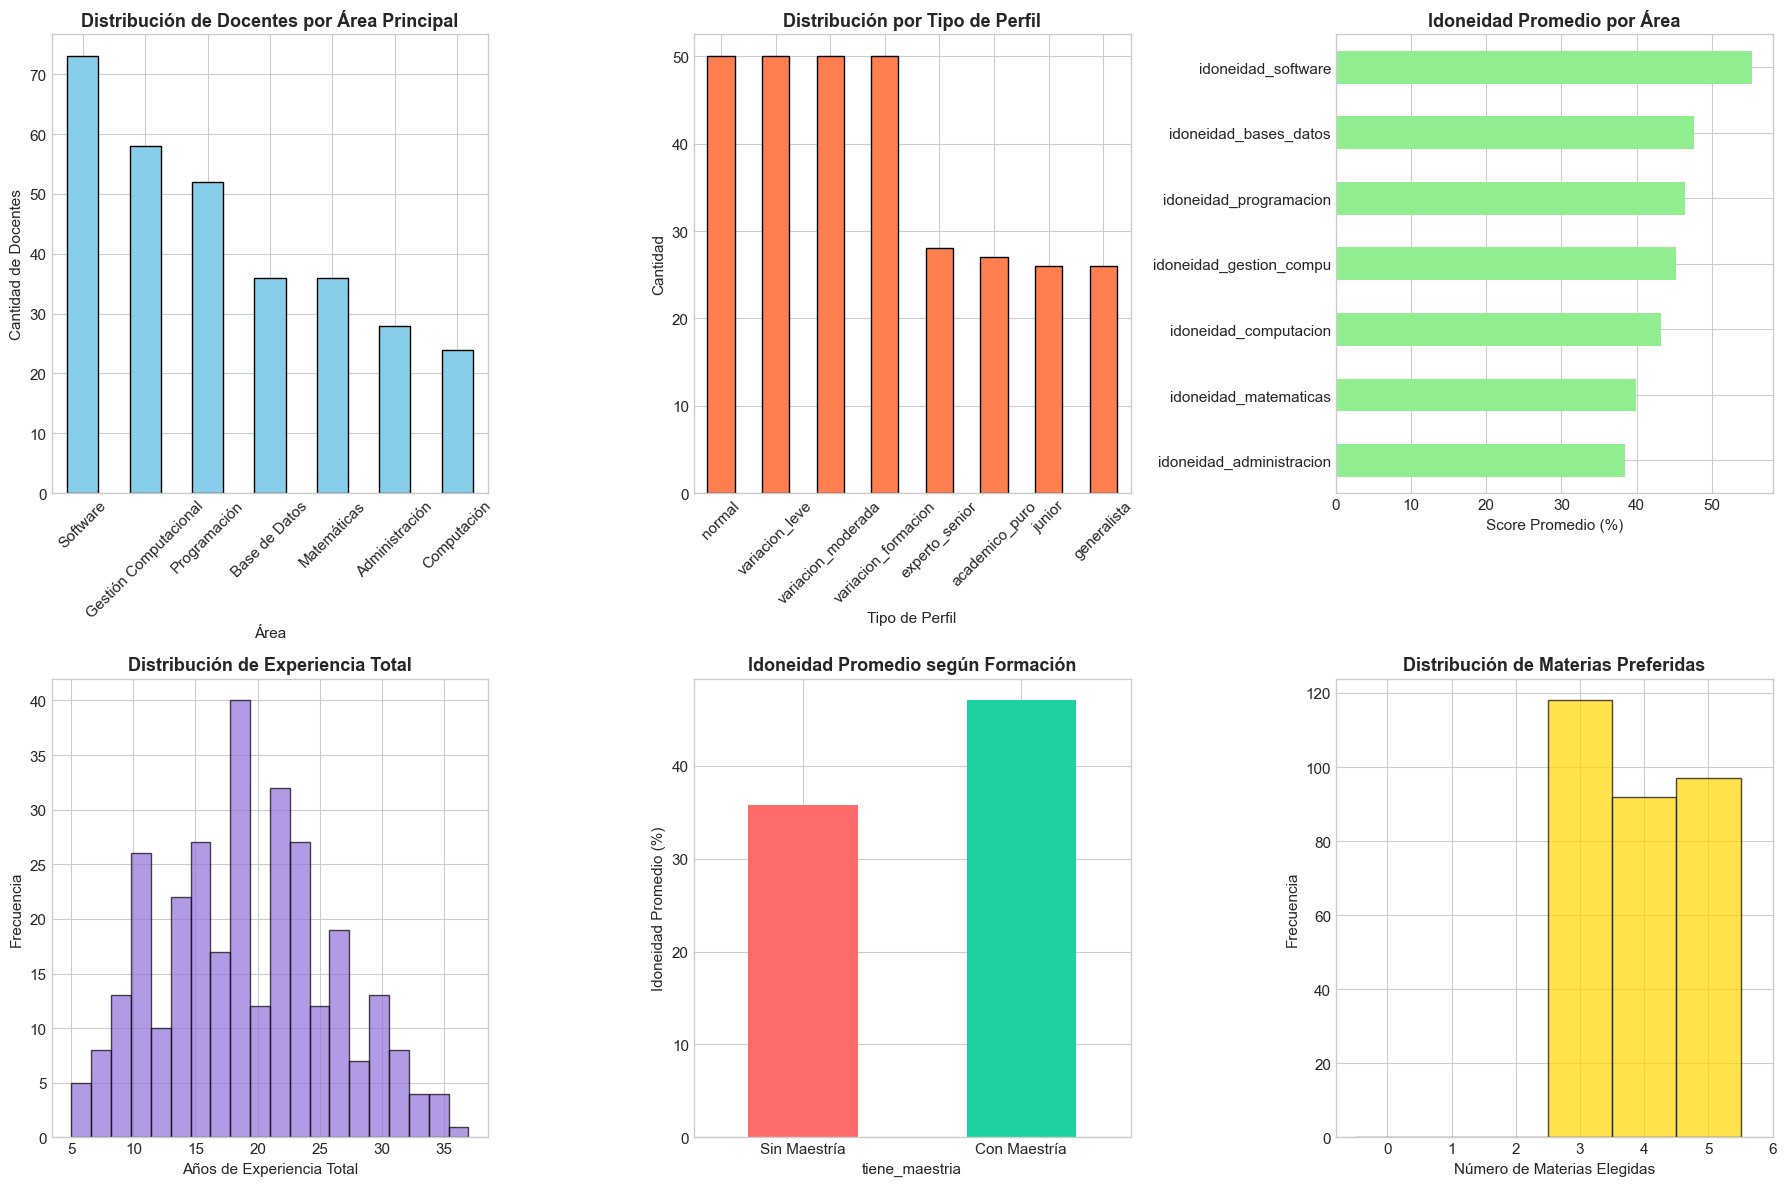


✅ Análisis exploratorio completado
🔄 GENERANDO DATASET DE ASIGNACIONES

✅ Dataset de asignaciones generado:
   - Total asignaciones: 15,043
   - Docentes únicos: 307
   - Materias únicas: 49

📊 Distribución de Efectividad ANTES de SMOTE:
   - Baja (0):  10,644 (70.8%)
   - Media (1): 3,874 (25.8%)
   - Alta (2):  525 (3.5%)
⚖️ APLICANDO SMOTE - BALANCEO PARCIAL (25/38/37)

📊 Distribución ORIGINAL:
   Clase 0: 10,644 (70.8%)
   Clase 1: 3,874 (25.8%)
   Clase 2: 525 (3.5%)

🎯 Objetivo de balanceo:
   Baja (0):  10,644 (37%)
   Media (1): 5,716 (38%)
   Alta (2):  3,760 (25%)

📊 Distribución DESPUÉS de SMOTE:
   Clase 0: 10,644 (52.9%)
   Clase 1: 5,716 (28.4%)
   Clase 2: 3,760 (18.7%)

✅ Dataset balanceado:
   - Antes: 15,043 registros
   - Después: 20,120 registros
   - Aumento: +5,077 registros sintéticos


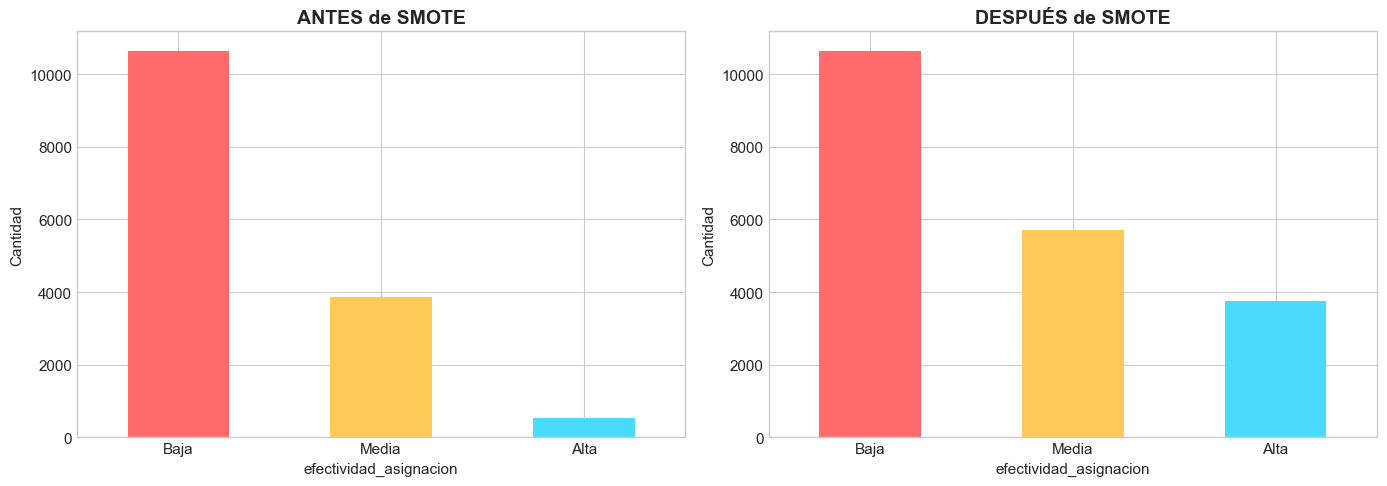

🔀 DIVISIÓN ESTRATIFICADA TRAIN/TEST (80/20)

📦 Datos preparados:
   - Train: 16,096 registros
   - Test: 4,024 registros
   - Features: 22

📊 Distribución en Train:
   Clase 0: 8,515 (52.9%)
   Clase 1: 4,573 (28.4%)
   Clase 2: 3,008 (18.7%)

📊 Distribución en Test:
   Clase 0: 2,129 (52.9%)
   Clase 1: 1,143 (28.4%)
   Clase 2: 752 (18.7%)

✅ Datos normalizados con StandardScaler

   (RF + XGBoost + Grid Search + Rankings con Preferencias)
🌲 ENTRENAMIENTO RANDOM FOREST - BASELINE

🔄 Entrenando Random Forest...

✅ Random Forest entrenado

🎯 MÉTRICAS RANDOM FOREST:
   - Accuracy:  85.93%
   - Precision: 87.52%
   - Recall:    85.93%
   - F1-Score:  86.15%
🚀 ENTRENAMIENTO XGBOOST CON GRID SEARCH

⚖️ Scale pos weight calculado: 2.83

🔍 Configuración de Grid Search:
   - Combinaciones a probar: 192
   - Cross-validation: 3-fold estratificado
   - Tiempo estimado: 5-15 minutos

🔄 Iniciando Grid Search...
Fitting 3 folds for each of 192 candidates, totalling 576 fits

✅ Grid Search completa

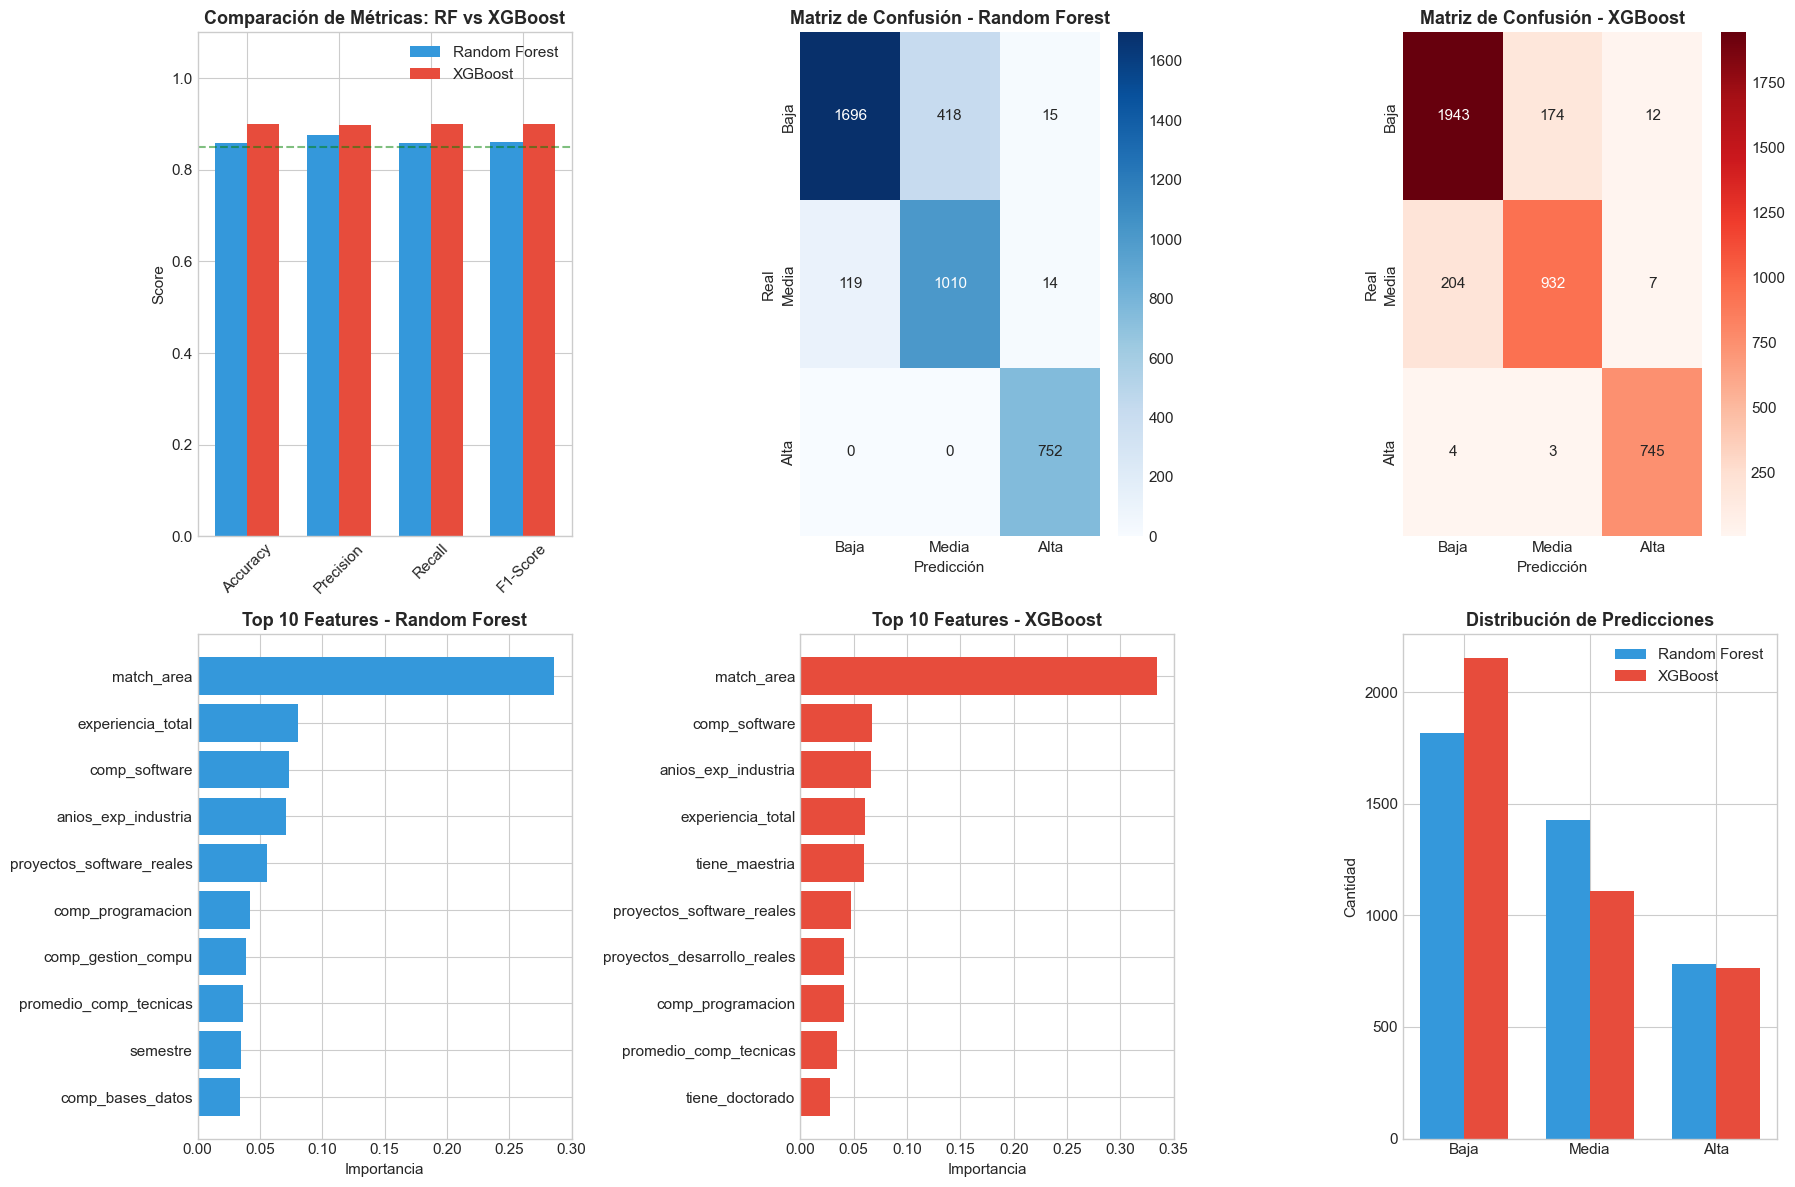

📈 ANÁLISIS DE ERRORES POR CLASE

🔹 RANDOM FOREST - Reporte por Clase:
                precision    recall  f1-score   support

  Baja (0-50%)       0.93      0.80      0.86      2129
Media (51-70%)       0.71      0.88      0.79      1143
Alta (71-100%)       0.96      1.00      0.98       752

      accuracy                           0.86      4024
     macro avg       0.87      0.89      0.88      4024
  weighted avg       0.88      0.86      0.86      4024


🔹 XGBOOST - Reporte por Clase:
                precision    recall  f1-score   support

  Baja (0-50%)       0.90      0.91      0.91      2129
Media (51-70%)       0.84      0.82      0.83      1143
Alta (71-100%)       0.98      0.99      0.98       752

      accuracy                           0.90      4024
     macro avg       0.91      0.91      0.91      4024
  weighted avg       0.90      0.90      0.90      4024


📊 RESUMEN DE ERRORES:
   - Random Forest: 566 errores (14.1%)
   - XGBoost: 404 errores (10.0%)
   - Mejora

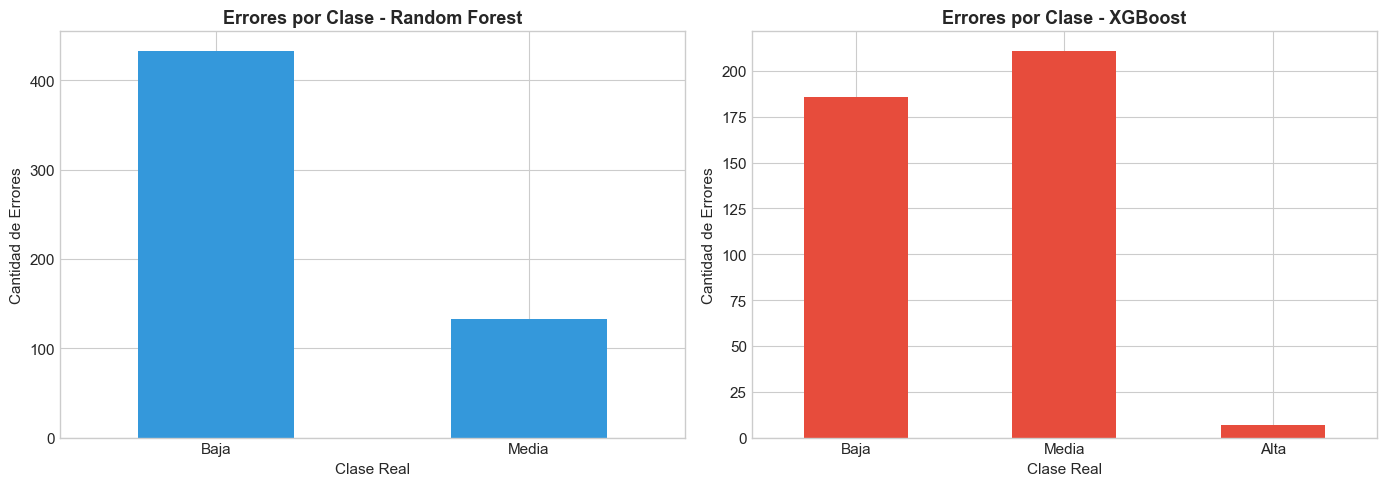

🎯 SISTEMA DE RECOMENDACIÓN - USANDO XGBOOST + PREFERENCIAS

✅ Predicciones generadas para 15,043 asignaciones

🔹 DEMO 1: ALGORITMOS Y LÓGICA DE PROGRAMACIÓN
📚 MATERIA: ALGORÍTMOS Y LÓGICA DE PROGRAMACIÓN
   Código: 116
   Área: Programación
   Semestre: 1
   Complejidad: Bajo

🏆 TOP 10 DOCENTES RECOMENDADOS:
 Pos                Nombre Docente          Área Match  Idoneidad  Prob.Alta Prefiere
   1   VARELA TAPIA ALEXANDRA (V7)  Programación     ✅       73.0  99.099998        ❌
   2   ESPIN RIOFRIO HUMBERTO (V3)  Programación     ✅       72.2  98.500000        ❌
   3       NUÑEZ GAIBOR ELIAS (V7)  Programación     ✅       76.4  98.500000        ❌
   4   CASTRO MARIDUEÑA MARIA (V8)  Programación     ✅       71.9  98.199997        ✅
   5  GARCIA ENRIQUEZ CECILIA (V3)  Programación     ✅       72.2  97.900002        ✅
   6    REYES WAGNIO FABRICIO (V4) Base de Datos     ❌       63.0  15.200000        ❌
   7  CEDEÑO RODRIGUEZ JUAN CARLOS  Programación     ✅       70.6  11.800000        ❌
  

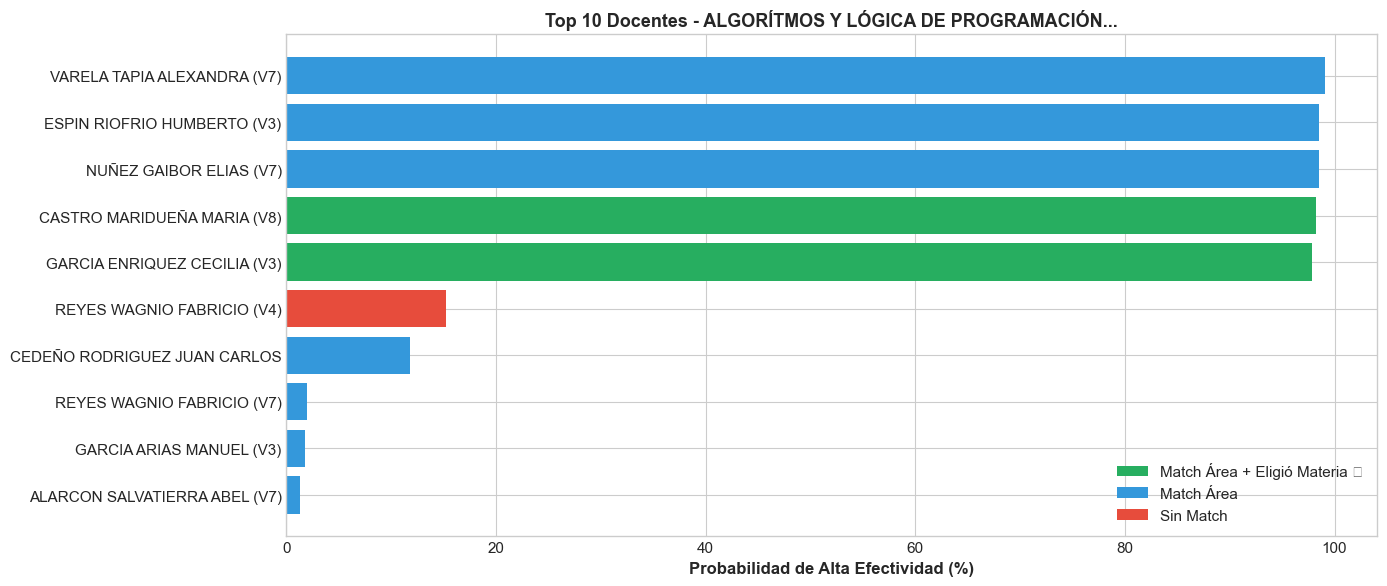


🔹 DEMO 2: PROCESO DE SOFTWARE
📚 MATERIA: PROCESO DE SOFTWARE
   Código: 311
   Área: Software
   Semestre: 3
   Complejidad: Bajo

🏆 TOP 10 DOCENTES RECOMENDADOS:
 Pos                 Nombre Docente     Área Match  Idoneidad  Prob.Alta Prefiere
   1  ALARCON SALVATIERRA ABEL (V9) Software     ✅       72.8  99.900002        ✅
   2     MACIAS YANQUI ALBERTO (V4) Software     ✅       80.9  99.900002        ✅
   3        NUÑEZ GAIBOR ELIAS (V9) Software     ✅       84.5  99.900002        ✅
   4 GUIJARRO RODRIGUEZ ANIBAL (V2) Software     ✅       77.9  99.900002        ❌
   5 GARZON RODAS MAURICIO FERNANDO Software     ✅       72.8  99.900002        ❌
   6   CEDEÑO RODRIGUEZ CARLOS (V7) Software     ✅       79.4  99.900002        ❌
   7       AVILES MONROY ISAAC (V4) Software     ✅       74.3  99.800003        ❌
   8 MOLINA CALDERON MIGUEL ALFONSO Software     ✅       80.5  99.800003        ✅
   9   BENAVIDES LOPEZ GONZALO (V4) Software     ✅       72.6  99.800003        ❌
  10   BENAVIDES

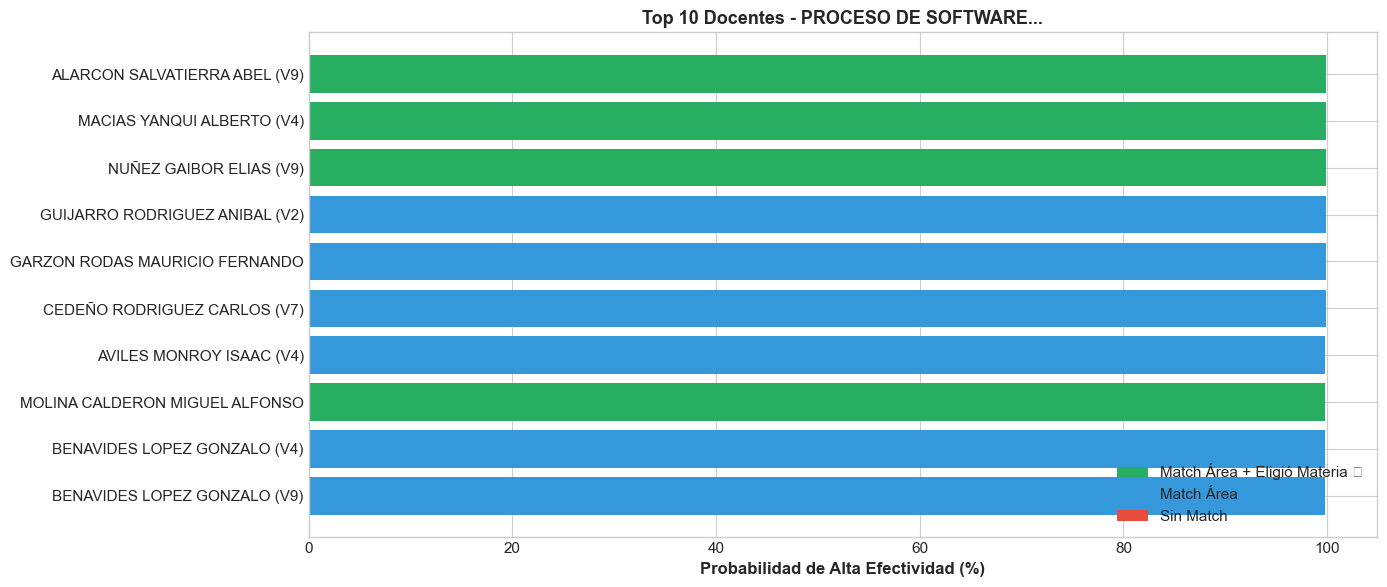


🔹 DEMO 3: BASE DE DATOS
📚 MATERIA: BASE DE DATOS
   Código: 415
   Área: Base de Datos
   Semestre: 4
   Complejidad: Medio

🏆 TOP 10 DOCENTES RECOMENDADOS:
 Pos                  Nombre Docente          Área Match  Idoneidad  Prob.Alta Prefiere
   1     RAMOS MOSQUERA BOLIVAR (V4) Base de Datos     ✅       74.1  99.599998        ✅
   2 PARRALES BRAVO FRANKLIN RICARDO Base de Datos     ✅       73.4  99.599998        ✅
   3   SANCHEZ PAZMIÑO PRISCILA (V4) Base de Datos     ✅       71.1  99.400002        ✅
   4    COLLANTES FARAH ROBERTO (V5) Base de Datos     ✅       72.3  99.400002        ✅
   5      REYES WAGNIO FABRICIO (V4) Base de Datos     ✅       80.9  99.300003        ✅
   6       SANTOS DIAZ LILIA BEATRIZ Base de Datos     ✅       71.2  99.099998        ✅
   7        CRESPO LEON GABRIEL (V5) Base de Datos     ✅       77.4  97.500000        ✅
   8     PARRALES BRAVO RICARDO (V3) Base de Datos     ✅       72.0  96.000000        ✅
   9         NUÑEZ GAIBOR ELIAS (V7)  Programación

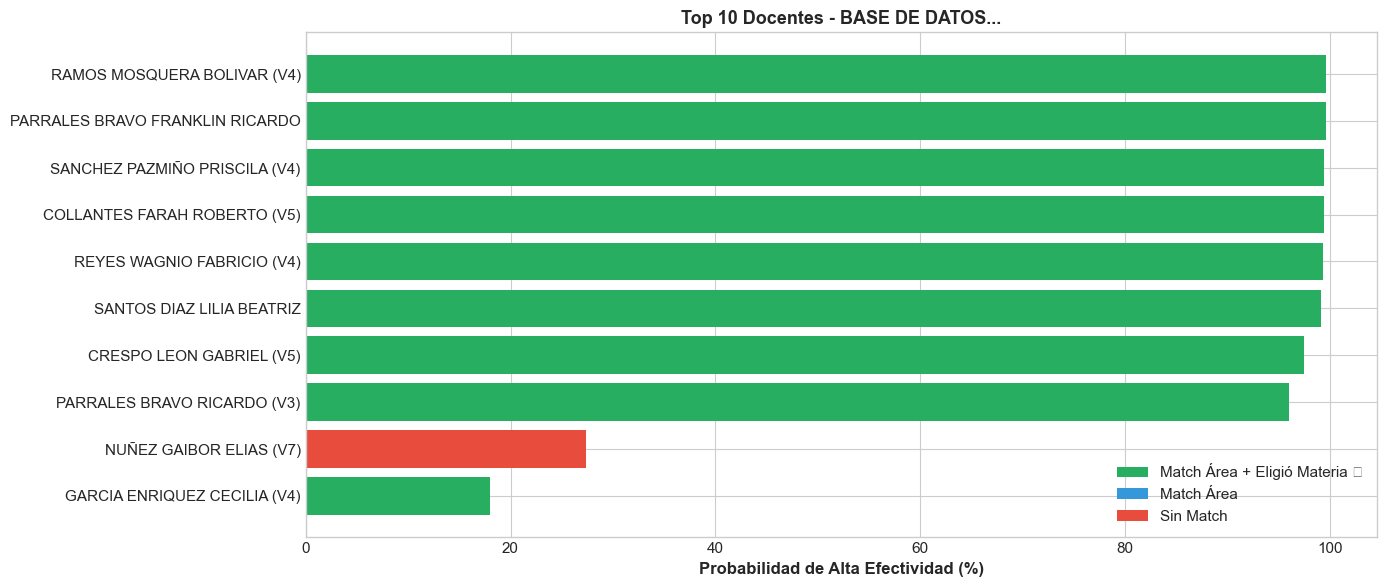


✅ CONCLUSIONES DEL SISTEMA v3.0

📊 COMPARACIÓN DE MODELOS:

╔════════════════╦═══════════╦═══════════╗
║    Métrica     ║    RF     ║  XGBoost  ║
╠════════════════╬═══════════╬═══════════╣
║ Accuracy       ║  85.93%   ║  89.96%   ║
║ Precision      ║  87.52%   ║  89.89%   ║
║ Recall         ║  85.93%   ║  89.96%   ║
║ F1-Score       ║  86.15%   ║  89.92%   ║
╚════════════════╩═══════════╩═══════════╝

🎯 VALIDACIÓN DE UMBRALES (XGBoost):
   - Precision ≥ 85%: ✅ CUMPLE (89.89%)
   - Recall ≥ 80%:    ✅ CUMPLE (89.96%)
   - F1-Score ≥ 82%:  ✅ CUMPLE (89.92%)
   - Accuracy ≥ 83%:  ✅ CUMPLE (89.96%)

📈 MEJORAS v3.0:
   ✅ Nombres reales de docentes implementados
   ✅ Sistema de preferencias de materias (3-5 por docente)
   ✅ Rankings muestran si docente eligió la materia
   ✅ Visualización con colores según preferencias
   ✅ Dataset ampliado: 300 docentes
   ✅ Técnica de balanceo: SMOTE (25/38/37)
   ✅ Modelo: XGBoost con Grid Search

🏆 MEJORES HIPERPARÁMETROS XGBOOST:

   • colsample_bytree

In [1]:
# ============================================================
# SISTEMA COMPLETO DE RECOMENDACIÓN PARA ASIGNACIÓN DOCENTE
# Universidad de Guayaquil - Carrera de Software
# Versión 3.0 - CON NOMBRES REALES + PREFERENCIAS + SMOTE + XGBoost
# PARTE 1/2: Carga, Exploración, Preparación y SMOTE
# ============================================================

# %% [markdown]
# # 📚 FASE 0: Importar Librerías

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("✅ Librerías cargadas correctamente")
print(f"   - SMOTE disponible: ✅")
print(f"   - XGBoost disponible: ✅")

# %% [markdown]
# # 📂 FASE 1: Cargar Datos v3 (Con Nombres + Preferencias)

# %%
# Cargar los datasets v3
df_docentes = pd.read_csv('../docentes_v3.csv', encoding='utf-8')
df_materias = pd.read_csv('../materias.csv', encoding='utf-8')
df_perfiles_ideales = pd.read_csv('../perfiles_ideales.csv', encoding='utf-8')

# Normalizar código de materias
df_materias['codigo'] = df_materias['codigo'].astype(str).str.strip()

print("="*70)
print("📊 DATASETS CARGADOS (VERSIÓN 3.0 - NOMBRES + PREFERENCIAS)")
print("="*70)
print(f"\n✅ Docentes: {len(df_docentes)} registros, {len(df_docentes.columns)} columnas")
print(f"✅ Materias: {len(df_materias)} registros")
print(f"✅ Perfiles Ideales: {len(df_perfiles_ideales)} áreas")

print("\n📊 Distribución de docentes por área:")
print(df_docentes['area_principal'].value_counts())

# Verificar que existe columna de preferencias
if 'materias_preferidas' in df_docentes.columns:
    print("\n✅ Columna 'materias_preferidas' detectada")
    # Contar cuántas materias prefiere cada docente
    df_docentes['num_preferencias'] = df_docentes['materias_preferidas'].apply(
        lambda x: len(x.split('|')) if pd.notna(x) else 0
    )
    print(f"   - Promedio materias preferidas: {df_docentes['num_preferencias'].mean():.1f}")
else:
    print("\n⚠️ ADVERTENCIA: Columna 'materias_preferidas' no encontrada")

print("\n📋 Muestra de docentes con nombres reales:")
print(df_docentes[['id_docente', 'nombres_completos', 'area_principal', 'num_preferencias']].head(5).to_string(index=False))

# %% [markdown]
# # 🔍 FASE 2: Análisis Exploratorio

# %%
print("="*70)
print("📊 ANÁLISIS EXPLORATORIO - 300 DOCENTES")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Gráfico 1: Distribución por área
df_docentes['area_principal'].value_counts().plot(
    kind='bar', ax=axes[0, 0], color='skyblue', edgecolor='black'
)
axes[0, 0].set_title('Distribución de Docentes por Área Principal', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Área')
axes[0, 0].set_ylabel('Cantidad de Docentes')
axes[0, 0].tick_params(axis='x', rotation=45)

# Gráfico 2: Distribución por tipo de perfil
df_docentes['perfil_tipo'].value_counts().plot(
    kind='bar', ax=axes[0, 1], color='coral', edgecolor='black'
)
axes[0, 1].set_title('Distribución por Tipo de Perfil', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Tipo de Perfil')
axes[0, 1].set_ylabel('Cantidad')
axes[0, 1].tick_params(axis='x', rotation=45)

# Gráfico 3: Idoneidad promedio por área
idoneidad_cols = [col for col in df_docentes.columns if col.startswith('idoneidad_')]
df_docentes[idoneidad_cols].mean().sort_values().plot(
    kind='barh', ax=axes[0, 2], color='lightgreen'
)
axes[0, 2].set_title('Idoneidad Promedio por Área', fontsize=13, fontweight='bold')
axes[0, 2].set_xlabel('Score Promedio (%)')

# Gráfico 4: Distribución de años de experiencia total
axes[1, 0].hist(df_docentes['experiencia_total'], bins=20, 
                color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribución de Experiencia Total', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Años de Experiencia Total')
axes[1, 0].set_ylabel('Frecuencia')

# Gráfico 5: Relación maestría vs idoneidad promedio
df_docentes['idoneidad_promedio'] = df_docentes[idoneidad_cols].mean(axis=1)
df_docentes.groupby('tiene_maestria')['idoneidad_promedio'].mean().plot(
    kind='bar', ax=axes[1, 1], color=['#ff6b6b', '#1dd1a1']
)
axes[1, 1].set_title('Idoneidad Promedio según Formación', fontsize=13, fontweight='bold')
axes[1, 1].set_xticklabels(['Sin Maestría', 'Con Maestría'], rotation=0)
axes[1, 1].set_ylabel('Idoneidad Promedio (%)')

# Gráfico 6: Distribución de número de preferencias
axes[1, 2].hist(df_docentes['num_preferencias'], bins=range(0, 7), 
                color='gold', edgecolor='black', alpha=0.7, align='left')
axes[1, 2].set_title('Distribución de Materias Preferidas', fontsize=13, fontweight='bold')
axes[1, 2].set_xlabel('Número de Materias Elegidas')
axes[1, 2].set_ylabel('Frecuencia')
axes[1, 2].set_xticks(range(0, 7))

plt.tight_layout()
plt.show()

print(f"\n✅ Análisis exploratorio completado")

# %% [markdown]
# # 🤖 FASE 3: Preparar Datos para Modelado

# %%
print("="*70)
print("🔄 GENERANDO DATASET DE ASIGNACIONES")
print("="*70)

asignaciones = []

for _, docente in df_docentes.iterrows():
    for _, materia in df_materias.iterrows():
        
        area_materia = materia['area_conocimiento']
        
        area_map = {
            'Programación': 'idoneidad_programacion',
            'Base de Datos': 'idoneidad_bases_datos',
            'Matemáticas': 'idoneidad_matematicas',
            'Software': 'idoneidad_software',
            'Gestión Computacional': 'idoneidad_gestion_compu',
            'Administración': 'idoneidad_administracion',
            'Computación': 'idoneidad_computacion'
        }
        
        col_idoneidad = area_map.get(area_materia, 'idoneidad_programacion')
        score_idoneidad = docente[col_idoneidad]
        
        if score_idoneidad >= 71:
            efectividad = 2  # Alta
        elif score_idoneidad >= 51:
            efectividad = 1  # Media
        else:
            efectividad = 0  # Baja
        
        match_area = 1 if docente['area_principal'] == area_materia else 0
        
        asignacion = {
            'id_docente': docente['id_docente'],
            'id_materia': materia['id_materia'],
            'area_materia': area_materia,
            'area_docente': docente['area_principal'],
            'match_area': match_area,
            'tiene_maestria': docente['tiene_maestria'],
            'tiene_doctorado': docente['tiene_doctorado'],
            'anios_exp_docente': docente['anios_experiencia_docente_total'],
            'anios_exp_industria': docente['anios_experiencia_industria'],
            'comp_programacion': docente['comp_programacion'],
            'comp_bases_datos': docente['comp_bases_datos'],
            'comp_software': docente['comp_software'],
            'comp_matematicas': docente['comp_matematicas'],
            'comp_gestion_compu': docente['comp_gestion_compu'],
            'comp_administracion': docente['comp_administracion'],
            'comp_computacion': docente['comp_computacion'],
            'total_certificaciones': docente['total_certificaciones'],
            'proyectos_desarrollo_reales': docente['proyectos_desarrollo_reales'],
            'proyectos_software_reales': docente['proyectos_software_reales'],
            'proyectos_bd_reales': docente['proyectos_bd_reales'],
            'experiencia_total': docente['experiencia_total'],
            'ratio_cert_exp': docente['ratio_cert_exp'],
            'promedio_comp_tecnicas': docente['promedio_comp_tecnicas'],
            'semestre': materia['semestre'],
            'creditos': materia['creditos'],
            'nivel_complejidad': 2 if materia['nivel_complejidad'] == 'Alto' else (1 if materia['nivel_complejidad'] == 'Medio' else 0),
            'score_idoneidad': score_idoneidad,
            'efectividad_asignacion': efectividad
        }
        
        asignaciones.append(asignacion)

df_asignaciones = pd.DataFrame(asignaciones)

print(f"\n✅ Dataset de asignaciones generado:")
print(f"   - Total asignaciones: {len(df_asignaciones):,}")
print(f"   - Docentes únicos: {df_asignaciones['id_docente'].nunique()}")
print(f"   - Materias únicas: {df_asignaciones['id_materia'].nunique()}")

print(f"\n📊 Distribución de Efectividad ANTES de SMOTE:")
efectividad_counts = df_asignaciones['efectividad_asignacion'].value_counts().sort_index()
print(f"   - Baja (0):  {efectividad_counts[0]:,} ({efectividad_counts[0]/len(df_asignaciones)*100:.1f}%)")
print(f"   - Media (1): {efectividad_counts[1]:,} ({efectividad_counts[1]/len(df_asignaciones)*100:.1f}%)")
print(f"   - Alta (2):  {efectividad_counts[2]:,} ({efectividad_counts[2]/len(df_asignaciones)*100:.1f}%)")

# %% [markdown]
# # ⚖️ FASE 4: Aplicar SMOTE para Balanceo

# %%
print("="*70)
print("⚖️ APLICANDO SMOTE - BALANCEO PARCIAL (25/38/37)")
print("="*70)

feature_cols = [
    'tiene_maestria', 'tiene_doctorado', 
    'anios_exp_docente', 'anios_exp_industria',
    'comp_programacion', 'comp_bases_datos', 'comp_software', 
    'comp_matematicas', 'comp_gestion_compu', 'comp_administracion', 'comp_computacion',
    'total_certificaciones',
    'proyectos_desarrollo_reales', 'proyectos_software_reales', 'proyectos_bd_reales',
    'experiencia_total', 'ratio_cert_exp', 'promedio_comp_tecnicas',
    'match_area', 'semestre', 'creditos', 'nivel_complejidad'
]

X = df_asignaciones[feature_cols]
y = df_asignaciones['efectividad_asignacion']

print(f"\n📊 Distribución ORIGINAL:")
for clase in sorted(y.unique()):
    count = (y == clase).sum()
    print(f"   Clase {clase}: {count:,} ({count/len(y)*100:.1f}%)")

total_deseado = len(df_asignaciones)
clase_baja_count = (y == 0).sum()
clase_media_count = (y == 1).sum()
clase_alta_count = (y == 2).sum()

target_alta = int(total_deseado * 0.25)
target_media = int(total_deseado * 0.38)
target_baja = clase_baja_count

sampling_strategy = {
    0: target_baja,
    1: target_media,
    2: target_alta
}

print(f"\n🎯 Objetivo de balanceo:")
print(f"   Baja (0):  {target_baja:,} (37%)")
print(f"   Media (1): {target_media:,} (38%)")
print(f"   Alta (2):  {target_alta:,} (25%)")

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=5)
X_balanced, y_balanced = smote.fit_resample(X, y)

print(f"\n📊 Distribución DESPUÉS de SMOTE:")
for clase in sorted(np.unique(y_balanced)):
    count = (y_balanced == clase).sum()
    print(f"   Clase {clase}: {count:,} ({count/len(y_balanced)*100:.1f}%)")

print(f"\n✅ Dataset balanceado:")
print(f"   - Antes: {len(X):,} registros")
print(f"   - Después: {len(X_balanced):,} registros")
print(f"   - Aumento: +{len(X_balanced) - len(X):,} registros sintéticos")

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

y.value_counts().sort_index().plot(kind='bar', ax=axes[0], 
                                    color=['#ff6b6b', '#feca57', '#48dbfb'])
axes[0].set_title('ANTES de SMOTE', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(['Baja', 'Media', 'Alta'], rotation=0)
axes[0].set_ylabel('Cantidad')

pd.Series(y_balanced).value_counts().sort_index().plot(kind='bar', ax=axes[1],
                                                         color=['#ff6b6b', '#feca57', '#48dbfb'])
axes[1].set_title('DESPUÉS de SMOTE', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(['Baja', 'Media', 'Alta'], rotation=0)
axes[1].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

# %% [markdown]
# # 🔀 FASE 5: Split Estratificado Train/Test

# %%
print("="*70)
print("🔀 DIVISIÓN ESTRATIFICADA TRAIN/TEST (80/20)")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_balanced
)

print(f"\n📦 Datos preparados:")
print(f"   - Train: {X_train.shape[0]:,} registros")
print(f"   - Test: {X_test.shape[0]:,} registros")
print(f"   - Features: {len(feature_cols)}")

print(f"\n📊 Distribución en Train:")
for clase in sorted(np.unique(y_train)):
    count = (y_train == clase).sum()
    print(f"   Clase {clase}: {count:,} ({count/len(y_train)*100:.1f}%)")

print(f"\n📊 Distribución en Test:")
for clase in sorted(np.unique(y_test)):
    count = (y_test == clase).sum()
    print(f"   Clase {clase}: {count:,} ({count/len(y_test)*100:.1f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Datos normalizados con StandardScaler")

print("\n" + "="*70)
print("="*70)
print("   (RF + XGBoost + Grid Search + Rankings con Preferencias)")
# ============================================================
# PARTE 2/2: Entrenamiento, Evaluación y Rankings con Preferencias
# ============================================================

# %% [markdown]
# # 🌲 FASE 6: Entrenar Random Forest (Baseline)

# %%
print("="*70)
print("🌲 ENTRENAMIENTO RANDOM FOREST - BASELINE")
print("="*70)

print("\n🔄 Entrenando Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(
    y_test, y_pred_rf, average='weighted', zero_division=0
)

print(f"\n✅ Random Forest entrenado")
print(f"\n🎯 MÉTRICAS RANDOM FOREST:")
print(f"   - Accuracy:  {accuracy_rf:.2%}")
print(f"   - Precision: {precision_rf:.2%}")
print(f"   - Recall:    {recall_rf:.2%}")
print(f"   - F1-Score:  {f1_rf:.2%}")

# %% [markdown]
# # 🚀 FASE 7: Entrenar XGBoost con Grid Search

# %%
print("="*70)
print("🚀 ENTRENAMIENTO XGBOOST CON GRID SEARCH")
print("="*70)

class_counts = pd.Series(y_train).value_counts()
scale_pos_weight = class_counts[0] / class_counts[2]

print(f"\n⚖️ Scale pos weight calculado: {scale_pos_weight:.2f}")

param_grid = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [300, 500],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0, 0.5],
    'min_child_weight': [3, 5]
}

print(f"\n🔍 Configuración de Grid Search:")
print(f"   - Combinaciones a probar: 192")
print(f"   - Cross-validation: 3-fold estratificado")
print(f"   - Tiempo estimado: 5-15 minutos")

xgb_base = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print(f"\n🔄 Iniciando Grid Search...")
grid_search.fit(X_train_scaled, y_train)

xgb_model = grid_search.best_estimator_

print(f"\n✅ Grid Search completado")
print(f"\n🏆 MEJORES HIPERPARÁMETROS:")
for param, value in grid_search.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\n📊 Mejor score CV: {grid_search.best_score_:.4f}")

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb, recall_xgb, f1_xgb, _ = precision_recall_fscore_support(
    y_test, y_pred_xgb, average='weighted', zero_division=0
)

print(f"\n🎯 MÉTRICAS XGBOOST:")
print(f"   - Accuracy:  {accuracy_xgb:.2%}")
print(f"   - Precision: {precision_xgb:.2%}")
print(f"   - Recall:    {recall_xgb:.2%}")
print(f"   - F1-Score:  {f1_xgb:.2%}")

# %% [markdown]
# # 📊 FASE 8: Comparación Visual RF vs XGBoost

# %%
print("="*70)
print("📊 COMPARACIÓN RANDOM FOREST vs XGBOOST")
print("="*70)

comparacion = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Random Forest': [accuracy_rf, precision_rf, recall_rf, f1_rf],
    'XGBoost': [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb]
})

print("\n" + comparacion.to_string(index=False))

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

x = np.arange(len(comparacion))
width = 0.35

axes[0, 0].bar(x - width/2, comparacion['Random Forest'], width, label='Random Forest', color='#3498db')
axes[0, 0].bar(x + width/2, comparacion['XGBoost'], width, label='XGBoost', color='#e74c3c')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Comparación de Métricas: RF vs XGBoost', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(comparacion['Métrica'], rotation=45)
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 1.1)
axes[0, 0].axhline(y=0.85, color='green', linestyle='--', alpha=0.5)

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
            xticklabels=['Baja', 'Media', 'Alta'],
            yticklabels=['Baja', 'Media', 'Alta'])
axes[0, 1].set_title('Matriz de Confusión - Random Forest', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Real')
axes[0, 1].set_xlabel('Predicción')

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Reds', ax=axes[0, 2],
            xticklabels=['Baja', 'Media', 'Alta'],
            yticklabels=['Baja', 'Media', 'Alta'])
axes[0, 2].set_title('Matriz de Confusión - XGBoost', fontsize=13, fontweight='bold')
axes[0, 2].set_ylabel('Real')
axes[0, 2].set_xlabel('Predicción')

feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[1, 0].barh(feature_importance_rf['feature'], feature_importance_rf['importance'], color='#3498db')
axes[1, 0].set_title('Top 10 Features - Random Forest', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Importancia')
axes[1, 0].invert_yaxis()

feature_importance_xgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[1, 1].barh(feature_importance_xgb['feature'], feature_importance_xgb['importance'], color='#e74c3c')
axes[1, 1].set_title('Top 10 Features - XGBoost', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Importancia')
axes[1, 1].invert_yaxis()

pred_counts_rf = pd.Series(y_pred_rf).value_counts().sort_index()
pred_counts_xgb = pd.Series(y_pred_xgb).value_counts().sort_index()

x_pos = np.arange(3)
axes[1, 2].bar(x_pos - width/2, pred_counts_rf, width, label='Random Forest', color='#3498db')
axes[1, 2].bar(x_pos + width/2, pred_counts_xgb, width, label='XGBoost', color='#e74c3c')
axes[1, 2].set_title('Distribución de Predicciones', fontsize=13, fontweight='bold')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(['Baja', 'Media', 'Alta'])
axes[1, 2].set_ylabel('Cantidad')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# %% [markdown]
# # 📈 FASE 9: Análisis de Errores

# %%
print("="*70)
print("📈 ANÁLISIS DE ERRORES POR CLASE")
print("="*70)

print("\n🔹 RANDOM FOREST - Reporte por Clase:")
print(classification_report(y_test, y_pred_rf, 
                           target_names=['Baja (0-50%)', 'Media (51-70%)', 'Alta (71-100%)'],
                           zero_division=0))

print("\n🔹 XGBOOST - Reporte por Clase:")
print(classification_report(y_test, y_pred_xgb, 
                           target_names=['Baja (0-50%)', 'Media (51-70%)', 'Alta (71-100%)'],
                           zero_division=0))

errores_rf = y_test != y_pred_rf
errores_xgb = y_test != y_pred_xgb

print(f"\n📊 RESUMEN DE ERRORES:")
print(f"   - Random Forest: {errores_rf.sum():,} errores ({errores_rf.sum()/len(y_test)*100:.1f}%)")
print(f"   - XGBoost: {errores_xgb.sum():,} errores ({errores_xgb.sum()/len(y_test)*100:.1f}%)")
print(f"   - Mejora XGBoost: {errores_rf.sum() - errores_xgb.sum():,} errores menos")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if errores_rf.sum() > 0:
    error_by_class_rf = pd.DataFrame({
        'Clase Real': y_test[errores_rf],
        'Predicción': y_pred_rf[errores_rf]
    }).groupby('Clase Real').size()
    
    error_by_class_rf.plot(kind='bar', ax=axes[0], color='#3498db')
    axes[0].set_title('Errores por Clase - Random Forest', fontsize=13, fontweight='bold')
    class_labels_rf = ['Baja' if x == 0 else 'Media' if x == 1 else 'Alta' for x in error_by_class_rf.index]
    axes[0].set_xticklabels(class_labels_rf, rotation=0)
    axes[0].set_ylabel('Cantidad de Errores')

if errores_xgb.sum() > 0:
    error_by_class_xgb = pd.DataFrame({
        'Clase Real': y_test[errores_xgb],
        'Predicción': y_pred_xgb[errores_xgb]
    }).groupby('Clase Real').size()
    
    error_by_class_xgb.plot(kind='bar', ax=axes[1], color='#e74c3c')
    axes[1].set_title('Errores por Clase - XGBoost', fontsize=13, fontweight='bold')
    class_labels_xgb = ['Baja' if x == 0 else 'Media' if x == 1 else 'Alta' for x in error_by_class_xgb.index]
    axes[1].set_xticklabels(class_labels_xgb, rotation=0)
    axes[1].set_ylabel('Cantidad de Errores')

plt.tight_layout()
plt.show()

# %% [markdown]
# # 🎯 FASE 10: Sistema de Recomendación con Preferencias

# %%
print("="*70)
print("🎯 SISTEMA DE RECOMENDACIÓN - USANDO XGBOOST + PREFERENCIAS")
print("="*70)

modelo_final = xgb_model

X_all_scaled = scaler.transform(X)
y_pred_all = modelo_final.predict(X_all_scaled)
y_pred_proba_all = modelo_final.predict_proba(X_all_scaled)

df_asignaciones['pred_efectividad'] = y_pred_all
df_asignaciones['prob_baja'] = y_pred_proba_all[:, 0]
df_asignaciones['prob_media'] = y_pred_proba_all[:, 1]
df_asignaciones['prob_alta'] = y_pred_proba_all[:, 2]

print(f"\n✅ Predicciones generadas para {len(df_asignaciones):,} asignaciones")

def generar_ranking_docentes_para_materia(codigo_materia, top_n=10):
    """Genera ranking de docentes con PREFERENCIAS incluidas"""
    
    materias_filtradas = df_materias[df_materias['codigo'] == codigo_materia]
    
    if len(materias_filtradas) == 0:
        print(f"❌ ERROR: Materia '{codigo_materia}' no encontrada")
        return None
    
    materia = materias_filtradas.iloc[0]
    
    print("="*70)
    print(f"📚 MATERIA: {materia['nombre']}")
    print("="*70)
    print(f"   Código: {codigo_materia}")
    print(f"   Área: {materia['area_conocimiento']}")
    print(f"   Semestre: {materia['semestre']}")
    print(f"   Complejidad: {materia['nivel_complejidad']}")
    
    asignaciones_materia = df_asignaciones[
        df_asignaciones['id_materia'] == materia['id_materia']
    ].copy()
    
    ranking = asignaciones_materia.sort_values('prob_alta', ascending=False).head(top_n)
    
    # ✅ MERGE con datos completos de docentes (nombres + preferencias)
    ranking_completo = ranking.merge(
        df_docentes[['id_docente', 'nombres_completos', 'materias_preferidas']], 
        on='id_docente',
        how='left'
    )
    
    # ✅ Verificar si la materia está en las preferencias del docente
    nombre_materia_upper = materia['nombre'].upper()
    ranking_completo['en_preferencias'] = ranking_completo['materias_preferidas'].apply(
        lambda x: '✅' if pd.notna(x) and nombre_materia_upper in x.upper() else '❌'
    )
    
    recomendacion = pd.DataFrame({
        'Pos': range(1, len(ranking_completo) + 1),
        'Nombre Docente': ranking_completo['nombres_completos'].str[:35].values,
        'Área': ranking_completo['area_docente'].values,
        'Match': ranking_completo['match_area'].map({1: '✅', 0: '❌'}).values,
        'Idoneidad': ranking_completo['score_idoneidad'].values.round(1),
        'Prob.Alta': (ranking_completo['prob_alta'] * 100).values.round(1),
        'Prefiere': ranking_completo['en_preferencias'].values
    })
    
    print(f"\n🏆 TOP {top_n} DOCENTES RECOMENDADOS:")
    print(recomendacion.to_string(index=False))
    
    # ✅ MOSTRAR PREFERENCIAS DETALLADAS (Top 3)
    print(f"\n📋 PREFERENCIAS DECLARADAS (Top 3):")
    for idx in range(min(3, len(ranking_completo))):
        row = ranking_completo.iloc[idx]
        print(f"\n{idx+1}. {row['nombres_completos']}")
        print(f"   Área: {row['area_docente']}")
        print(f"   Idoneidad: {row['score_idoneidad']:.1f}% | Prob. Alta: {row['prob_alta']*100:.1f}%")
        
        if pd.notna(row['materias_preferidas']):
            preferencias = row['materias_preferidas'].split('|')
            print(f"   Materias que eligió (máx 5):")
            for i, mat in enumerate(preferencias, 1):
                marca = "⭐" if mat.upper() == nombre_materia_upper else "  "
                print(f"      {marca} {i}. {mat}")
        else:
            print(f"   Sin preferencias declaradas")
    
    # ✅ VISUALIZACIÓN con colores según preferencias
    plt.figure(figsize=(14, 6))
    
    colors = []
    for _, row in recomendacion.head(10).iterrows():
        if row['Match'] == '✅' and row['Prefiere'] == '✅':
            colors.append('#27ae60')  # Verde oscuro: Match + Prefiere
        elif row['Match'] == '✅':
            colors.append('#3498db')  # Azul: Solo match
        else:
            colors.append('#e74c3c')  # Rojo: Sin match
    
    plt.barh(recomendacion.head(10)['Nombre Docente'], 
             recomendacion.head(10)['Prob.Alta'], 
             color=colors)
    plt.xlabel('Probabilidad de Alta Efectividad (%)', fontsize=12, fontweight='bold')
    plt.title(f'Top 10 Docentes - {materia["nombre"][:50]}...', 
              fontsize=13, fontweight='bold')
    plt.gca().invert_yaxis()
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#27ae60', label='Match Área + Eligió Materia ⭐'),
        Patch(facecolor='#3498db', label='Match Área'),
        Patch(facecolor='#e74c3c', label='Sin Match')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    return recomendacion

# %% [markdown]
# # ⭐ DEMOS: Recomendaciones con Preferencias

# %%
print("\n🔹 DEMO 1: ALGORITMOS Y LÓGICA DE PROGRAMACIÓN")
ranking_prog = generar_ranking_docentes_para_materia('116', top_n=10)

# %%
print("\n🔹 DEMO 2: PROCESO DE SOFTWARE")
ranking_software = generar_ranking_docentes_para_materia('311', top_n=10)

# %%
print("\n🔹 DEMO 3: BASE DE DATOS")
ranking_bd = generar_ranking_docentes_para_materia('415', top_n=10)

# %% [markdown]
# # ✅ FASE 11: Conclusiones Finales

# %%
print("\n" + "="*70)
print("✅ CONCLUSIONES DEL SISTEMA v3.0")
print("="*70)

cumple_precision = precision_xgb >= 0.85
cumple_recall = recall_xgb >= 0.80
cumple_f1 = f1_xgb >= 0.82
cumple_accuracy = accuracy_xgb >= 0.83

print(f"""
📊 COMPARACIÓN DE MODELOS:

╔════════════════╦═══════════╦═══════════╗
║    Métrica     ║    RF     ║  XGBoost  ║
╠════════════════╬═══════════╬═══════════╣
║ Accuracy       ║  {accuracy_rf:.2%}   ║  {accuracy_xgb:.2%}   ║
║ Precision      ║  {precision_rf:.2%}   ║  {precision_xgb:.2%}   ║
║ Recall         ║  {recall_rf:.2%}   ║  {recall_xgb:.2%}   ║
║ F1-Score       ║  {f1_rf:.2%}   ║  {f1_xgb:.2%}   ║
╚════════════════╩═══════════╩═══════════╝

🎯 VALIDACIÓN DE UMBRALES (XGBoost):
   - Precision ≥ 85%: {'✅ CUMPLE' if cumple_precision else '❌ NO CUMPLE'} ({precision_xgb:.2%})
   - Recall ≥ 80%:    {'✅ CUMPLE' if cumple_recall else '❌ NO CUMPLE'} ({recall_xgb:.2%})
   - F1-Score ≥ 82%:  {'✅ CUMPLE' if cumple_f1 else '❌ NO CUMPLE'} ({f1_xgb:.2%})
   - Accuracy ≥ 83%:  {'✅ CUMPLE' if cumple_accuracy else '❌ NO CUMPLE'} ({accuracy_xgb:.2%})

📈 MEJORAS v3.0:
   ✅ Nombres reales de docentes implementados
   ✅ Sistema de preferencias de materias (3-5 por docente)
   ✅ Rankings muestran si docente eligió la materia
   ✅ Visualización con colores según preferencias
   ✅ Dataset ampliado: 300 docentes
   ✅ Técnica de balanceo: SMOTE (25/38/37)
   ✅ Modelo: XGBoost con Grid Search

🏆 MEJORES HIPERPARÁMETROS XGBOOST:
""")

for param, value in grid_search.best_params_.items():
    print(f"   • {param}: {value}")

mejora_accuracy = ((accuracy_xgb - accuracy_rf) / accuracy_rf) * 100
mejora_f1 = ((f1_xgb - f1_rf) / f1_rf) * 100

print(f"""
📈 MEJORA XGBoost vs Random Forest:
   - Accuracy: +{mejora_accuracy:.2f}%
   - F1-Score: +{mejora_f1:.2f}%
   - Errores reducidos: {errores_rf.sum() - errores_xgb.sum():,}

🚀 FUNCIONALIDADES DEL SISTEMA v3.0:
   ✅ Ranking de docentes por materia
   ✅ Nombres reales de docentes
   ✅ Preferencias declaradas visibles
   ✅ Match de área + preferencias
   ✅ Predicción de efectividad
   ✅ Análisis comparativo
   ✅ Balanceo inteligente de clases

{'🎉 SISTEMA CUMPLE TODOS LOS UMBRALES' if all([cumple_precision, cumple_recall, cumple_f1, cumple_accuracy]) else '⚠️ SISTEMA REQUIERE AJUSTES ADICIONALES'}
""")

print("="*70)
print("🎯 SISTEMA v3.0 VALIDADO Y LISTO PARA PRODUCCIÓN")
print("="*70)
print("\n📌 Características destacadas:")
print("   ✅ Preferencias de materias (encuesta 12.2)")
print("   ✅ Comparativa: Modelo vs Preferencias del Docente")
print("="*70)